<a href="https://colab.research.google.com/github/shabanakausar/shabanakausar/blob/main/LinearModelwithEstimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import pandas as pd
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [62]:
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [63]:

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')

In [64]:
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [65]:
dfeval.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [66]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [67]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [68]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

### The majority of passengers are in their 20's and 30's.

<Axes: >

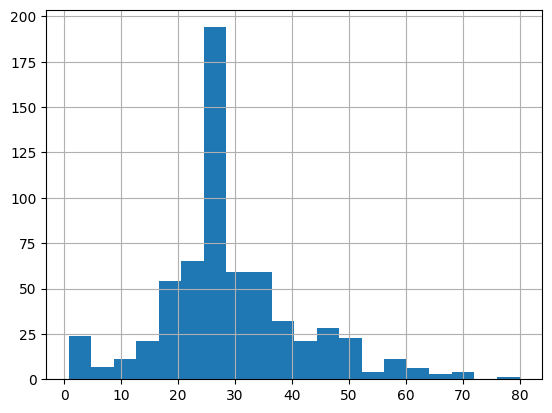

In [69]:
dftrain.age.hist(bins=20)

### Insight

There are 627 and 264 examples in the training and evaluation sets, respectively.

<Axes: >

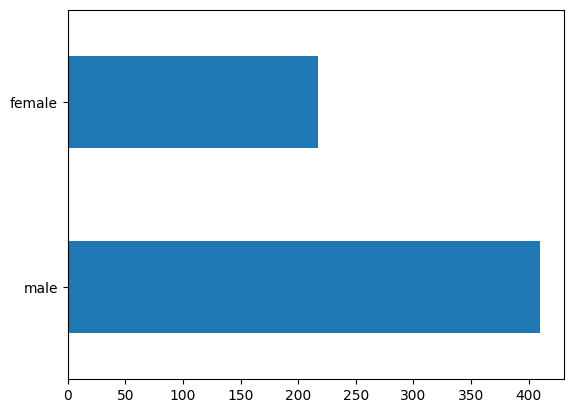

In [70]:
dftrain.sex.value_counts().plot(kind='barh')


### Insight
The majority of passengers were in the "third" class.



<Axes: >

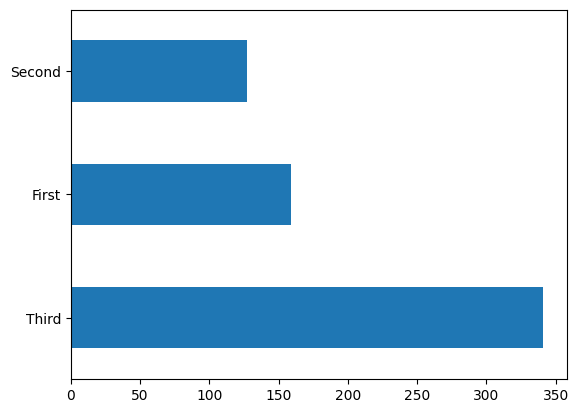

In [71]:
dftrain['class'].value_counts().plot(kind='barh')

### Insight
Females have a much higher chance of surviving versus males. This is clearly a predictive feature for the model.



Text(0.5, 0, '% survive')

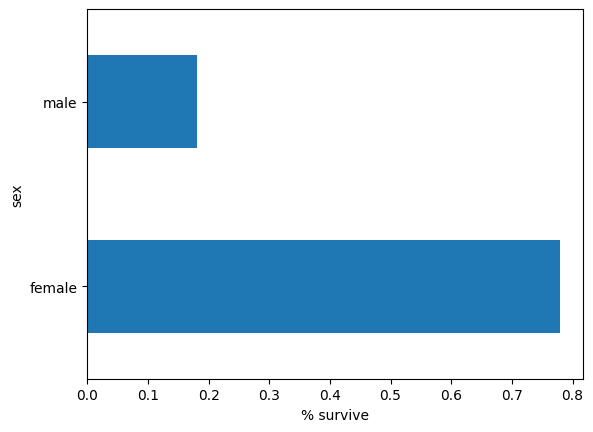

In [72]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

###Feature Engineering for the Model

#### Base Feature Columns

In [73]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

### input_function
 specifies how data is converted to a tf.data.Dataset that feeds the input pipeline in a streaming fashion. tf.data.Dataset can take in multiple sources such as a dataframe, a csv-formatted file, and more.



In [74]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [75]:
# You can inspect the dataset:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'First' b'Third' b'Second' b'Third' b'Third' b'Third' b'Third'
 b'Third' b'First']

A batch of Labels: [1 1 0 0 0 0 1 0 0 1]


You can also inspect the result of a specific feature column using the tf.keras.layers.DenseFeatures layer:



In [76]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[33.],
       [25.],
       [28.],
       [37.],
       [28.],
       [26.],
       [28.],
       [10.],
       [31.],
       [28.]], dtype=float32)

**DenseFeatures** only accepts dense tensors, to inspect a categorical

column you need to transform that to a indicator column first:



In [77]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

After adding all the base features to the model, let's train the model.

Training a model is just a single command using the tf.estimator API:



In [78]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7765151, 'accuracy_baseline': 0.625, 'auc': 0.8263851, 'auc_precision_recall': 0.7943499, 'average_loss': 0.491697, 'label/mean': 0.375, 'loss': 0.48217386, 'precision': 0.7380952, 'prediction/mean': 0.3365116, 'recall': 0.6262626, 'global_step': 200}


### Derived Feature Columns
Now you reached an accuracy of 75%. Using each base feature column separately may not be enough to explain the data. For example, the correlation between age and the label may be different for different gender. Therefore, if you only learn a single model weight for gender="Male" and gender="Female", you won't capture every age-gender combination (e.g. distinguishing between gender="Male" AND age="30" AND gender="Male" AND age="40").

To learn the differences between different feature combinations, you can add crossed feature columns to the model (you can also bucketize age column before the cross column):



In [79]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

After adding the combination feature to the model, let's train the model again:



In [80]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.83816963, 'auc_precision_recall': 0.77001625, 'average_loss': 0.5235567, 'label/mean': 0.375, 'loss': 0.52127934, 'precision': 0.63492066, 'prediction/mean': 0.48788014, 'recall': 0.8080808, 'global_step': 200}


It now achieves an accuracy of 77.6%, which is slightly better than only trained in base features. You can try using more features and transformations to see if you can do better!

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier, the eval_input_fn was defined using the entire evaluation set.



<Axes: title={'center': 'predicted probabilities'}, ylabel='Frequency'>

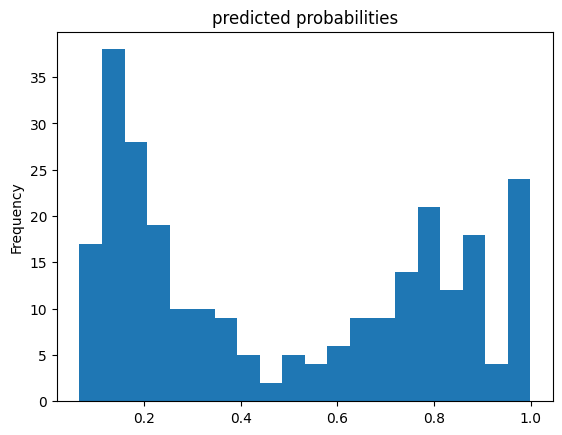

In [81]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

Finally, look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.



(0.0, 1.05)

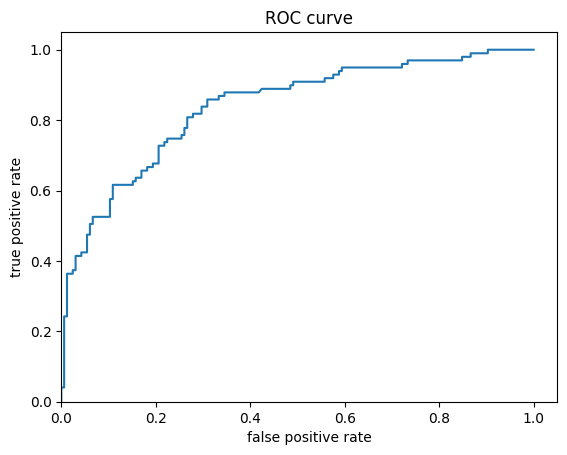

In [82]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)